## Load dataset

In [46]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt


train_separable = pd.read_csv('../../input/A2-ring/A2-ring-separable.txt', sep="\t", header=None)
train_merged = pd.read_csv('../../input/A2-ring/A2-ring-merged.txt', sep="\t", header=None)
test = pd.read_csv('../../input/A2-ring/A2-ring-test.txt', sep="\t", header=None)
columns = ['Feature1', 'Feature2', 'Class']
train_separable.columns, train_merged.columns, test.columns = columns, columns, columns

X_train_sep = train_separable.iloc[:, :-1]
y_train_sep = train_separable.iloc[:, -1]
X_train_mrg = train_merged.iloc[:, :-1]
y_train_mrg = train_merged.iloc[:, -1]
X_test = test.iloc[:, :-1]
y_test = test.iloc[:, -1]



## Functions for training and evaluation

In [47]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

# Function for training and evaluating the model
def train_and_evaluate(X_train, y_train, X_test, y_test, dataset_name):
    param_grid = {
        'hidden_layer_sizes': [(10,), (50,), (100,)],  
        'learning_rate_init': [0.001, 0.01, 0.1],    
        'max_iter': [1000, 1500, 2000]                  
    }

    mlp = MLPClassifier(solver='adam', random_state=42)
    grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train.values.ravel())

    print(f"\nBest parameters for {dataset_name}:", grid_search.best_params_)
    print(f"Best score (accuracy) for {dataset_name}:", grid_search.best_score_)

    best_model = grid_search.best_estimator_
    y_pred_test = best_model.predict(X_test)

    conf_matrix = confusion_matrix(y_test, y_pred_test)
    print(f"Confusion Matrix for {dataset_name}:\n", conf_matrix)

    plot_roc_curve_and_auc(y_test, y_pred_test, dataset_name)
    return best_model

# Function to plot ROC curve and calculate AUC
def plot_roc_curve_and_auc(y_val, y_pred, title):
    fpr, tpr, thresholds = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {title}')
    plt.legend(loc="lower right")
    plt.show()

    print(f"ROC AUC Score for {title}: ", roc_auc)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Accuracy for {title}: ", accuracy)
    classification_error = 1 - accuracy
    print(f"Classification Error for {title}: ", classification_error)


## Cross-validation 

In [48]:
import numpy as np
from sklearn.model_selection import cross_val_score

def perform_cross_validation(X_train, y_train, classifier, cv_folds=5):
    # Perform cross-validation
    cv_scores = cross_val_score(classifier, X_train, y_train.values.ravel(), cv=cv_folds, scoring='accuracy')
    
    # Calculate and return the average classification error
    return np.mean(1 - cv_scores)


# Define your MLPClassifier
mlp_ring = MLPClassifier(hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=1000, random_state=42)

# Cross-validation on the separable ring dataset
cv_error_separable = perform_cross_validation(X_train_sep, y_train_sep, mlp_ring)
print(f"Cross-Validation Error (Separable Ring Dataset): {cv_error_separable}")

# Cross-validation on the merged ring dataset
cv_error_merged = perform_cross_validation(X_train_mrg, y_train_mrg, mlp_ring)
print(f"Cross-Validation Error (Merged Ring Dataset): {cv_error_merged}")


Cross-Validation Error (Separable Ring Dataset): 0.011599999999999966
Cross-Validation Error (Merged Ring Dataset): 0.22750000000000004


## Train and Evaluate on Separable Data


Best parameters for Separable Ring Dataset: {'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01, 'max_iter': 1000}
Best score (accuracy) for Separable Ring Dataset: 0.9884000000000001
Confusion Matrix for Separable Ring Dataset:
 [[5276   57]
 [  39 4628]]


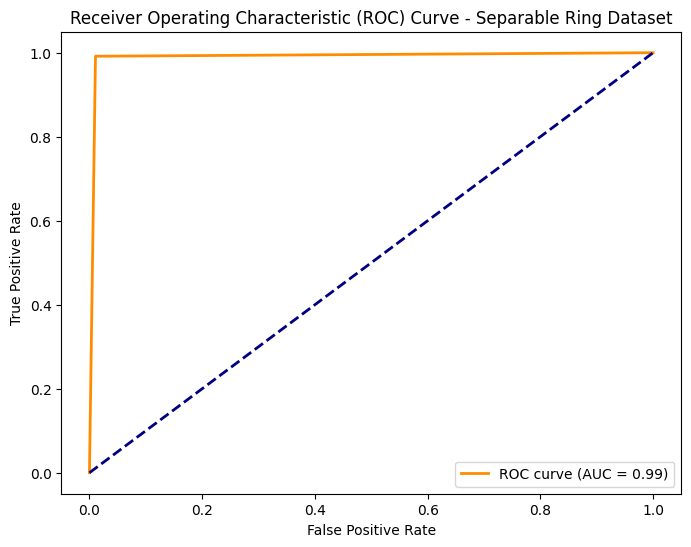

ROC AUC Score for Separable Ring Dataset:  0.9904776430142483
Accuracy for Separable Ring Dataset:  0.9904
Classification Error for Separable Ring Dataset:  0.009600000000000053
Test Set Error (Separable Ring Dataset): 0.009600000000000053

Best parameters for Merged Ring Dataset: {'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01, 'max_iter': 1000}
Best score (accuracy) for Merged Ring Dataset: 0.7737999999999999
Confusion Matrix for Merged Ring Dataset:
 [[5248   85]
 [ 441 4226]]


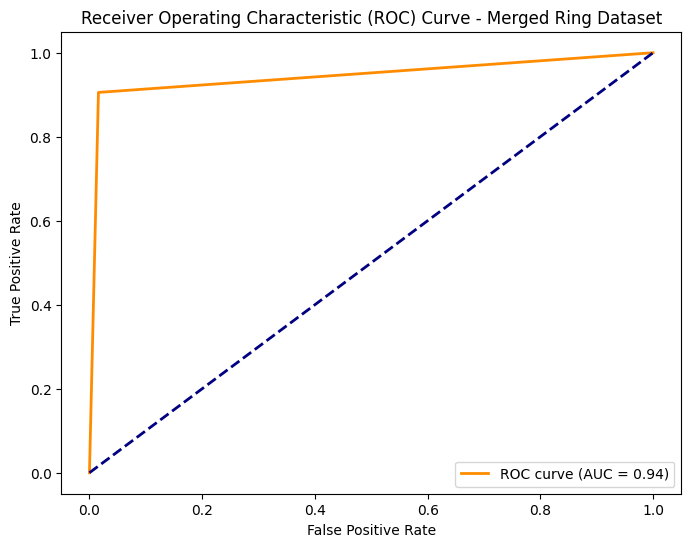

ROC AUC Score for Merged Ring Dataset:  0.9447841266809409
Accuracy for Merged Ring Dataset:  0.9474
Classification Error for Merged Ring Dataset:  0.05259999999999998
Test Set Error (Merged Ring Dataset): 0.05259999999999998
Comparison for Separable Ring - CV Error: 0.011599999999999966, Test Error: 0.009600000000000053
Comparison for Merged Ring - CV Error: 0.22750000000000004, Test Error: 0.05259999999999998


In [49]:
# Train and evaluate on the separable ring dataset
best_model_sep = train_and_evaluate(X_train_sep, y_train_sep, X_test, y_test, "Separable Ring Dataset")
test_error_sep = 1 - best_model_sep.score(X_test, y_test)
print(f"Test Set Error (Separable Ring Dataset): {test_error_sep}")

# Train and evaluate on the merged ring dataset
best_model_mrg = train_and_evaluate(X_train_mrg, y_train_mrg, X_test, y_test, "Merged Ring Dataset")
test_error_mrg = 1 - best_model_mrg.score(X_test, y_test)
print(f"Test Set Error (Merged Ring Dataset): {test_error_mrg}")

# Compare the cross-validation error with the test set error
print(f"Comparison for Separable Ring - CV Error: {cv_error_separable}, Test Error: {test_error_sep}")
print(f"Comparison for Merged Ring - CV Error: {cv_error_merged}, Test Error: {test_error_mrg}")
